In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
%matplotlib inline
import matplotlib.pyplot as plt
# !pip install dtreeviz
# !pip install graphviz

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset = pd.read_csv('/Users/justinchen/Documents/mental_health_subreddits_dataset.csv')

In [4]:
sample = dataset.sample(20000)
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
25178,11844273,depression,1602438288,2020 is the yearbI died. Laid off from work an...,-0.6412
9990,5799794,covid19_support,1619875360,Not trying to fear monger. This is just my opi...,0.9160
10859,6257371,mentalhealth,1618562534,Dude I’m in the same boat except for the *ahem...,0.6258
9730,5683591,covid19_support,1620224404,"I think its my only option, I guess I should j...",0.5016
24726,11696047,covid19_support,1602892991,You are doing the right thing 100%!!! I am in ...,0.9755


In [5]:
count = Counter()
for index, row in sample.iterrows():
    if row['subreddit.name'] == 'anxiety':
        count['anxiety'] += 1
    if row['subreddit.name'] == 'depression':
        count['depression'] += 1
    if row['subreddit.name'] == 'suicidewatch':
        count['SuicideWatch'] += 1
    if row['subreddit.name'] == 'mentalhealth':
        count['mentalhealth'] += 1
    if row['subreddit.name'] == 'covid19_support':
        count['COVID19_support'] += 1
count

Counter({'depression': 2536,
         'COVID19_support': 6943,
         'mentalhealth': 1479,
         'anxiety': 7288,
         'SuicideWatch': 1754})

## Preprocessing

In [6]:
import re #regex library used for substituting words

In [7]:
#removing stopwords and urls, stemming, making lowercase 
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def cleaning(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [8]:
def post_cleaning(text):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ',text)

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    
    #remove digits
    processed_feature = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", processed_feature)

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    return processed_feature

In [9]:
#above functions combined
def preprocessing(text):
    line = cleaning(text)
    line = post_cleaning (line)
    return line

In [10]:
sample.body = sample.body.apply(lambda x: preprocessing(x))

In [11]:
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
10804,6228784,suicidewatch,1618647145,way get dirt broke know anyone state due covid...,0.7496
21007,10365549,suicidewatch,1606581431,done research done hard enough without covid c...,0.5487
5788,3582971,covid19_support,1627404911,talking early onset dementia read example,0.0000
12504,6999970,anxiety,1616251936,anxious covid think going needle feels manageable,-0.3167
9614,5626949,depression,1620383148,trying better since came army years ago hence ...,0.7774


In [11]:
for sentiment in sample['sentiment']:
    if sentiment > 0:
        sample['sentiment'].replace({sentiment : 'positive'}, inplace=True)
    if sentiment < 0:
        sample['sentiment'].replace({sentiment : 'negative'}, inplace=True)
    else:
        sample['sentiment'].replace({sentiment : 'neutral'}, inplace=True)

Text(0.5, 1.0, 'Sentiment Data Distribution')

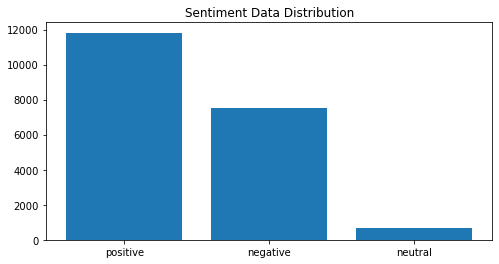

In [12]:
#Graphing
val_count = sample.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [13]:
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
43069,16933287,covid19_support,1586118631,little brother sick christmas week covid sympt...,negative
34885,14698214,depression,1593887677,yeah really bad covid social distancing enable...,negative
24591,11652122,suicidewatch,1603057097,dude death answer tried kill work understood w...,positive
24051,11480801,covid19_support,1603590027,hey thanks replies input greatly appreciated y...,positive
40029,16087761,anxiety,1588880060,big emily oster fan economist specializes pare...,positive


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(sample, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 16000
Test Data size 4000


## Vectorizing

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
vectorizer = TfidfVectorizer(max_features=10000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [17]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (16000, 8944)
x_test Shape: (4000, 8944)


In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (16000, 1)
y_test shape: (4000, 1)


## Random Forest Model

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
model = RandomForestClassifier()
model.fit(x_train, y_train.ravel())
predicted_labels = model.predict(x_test)
print ('Accuracy:', model.score(x_test, y_test))

Accuracy: 0.752


## Feature Importances

In [22]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.tree import export_graphviz

In [23]:
from sklearn.tree import export_text
for tree in model.estimators_:
    text_representation = export_text(tree, feature_names = vectorizer.get_feature_names())
    print(text_representation)

/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


|--- thead <= 0.14
|   |--- please <= 0.23
|   |   |--- hi <= 0.09
|   |   |   |--- definitely <= 0.01
|   |   |   |   |--- suggest <= 0.06
|   |   |   |   |   |--- pain <= 0.11
|   |   |   |   |   |   |--- dead <= 0.11
|   |   |   |   |   |   |   |--- look <= 0.04
|   |   |   |   |   |   |   |   |--- friends <= 0.06
|   |   |   |   |   |   |   |   |   |--- anxiety <= 0.09
|   |   |   |   |   |   |   |   |   |   |--- cold <= 0.17
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 385
|   |   |   |   |   |   |   |   |   |   |--- cold >  0.17
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 28
|   |   |   |   |   |   |   |   |   |--- anxiety >  0.09
|   |   |   |   |   |   |   |   |   |   |--- years <= 0.06
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 86
|   |   |   |   |   |   |   |   |   |   |--- years >  0.06
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   

|--- die <= 0.04
|   |--- thead <= 0.14
|   |   |--- questions <= 0.07
|   |   |   |--- helps <= 0.03
|   |   |   |   |--- attack <= 0.02
|   |   |   |   |   |--- little <= 0.01
|   |   |   |   |   |   |--- help <= 0.05
|   |   |   |   |   |   |   |--- died <= 0.04
|   |   |   |   |   |   |   |   |--- common <= 0.03
|   |   |   |   |   |   |   |   |   |--- nice <= 0.08
|   |   |   |   |   |   |   |   |   |   |--- yesterday <= 0.39
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 382
|   |   |   |   |   |   |   |   |   |   |--- yesterday >  0.39
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |   |--- nice >  0.08
|   |   |   |   |   |   |   |   |   |   |--- autoimmune <= 0.13
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |   |--- autoimmune >  0.13
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- common

|--- anything <= 0.05
|   |--- compromised <= 0.15
|   |   |--- looking <= 0.12
|   |   |   |--- bad <= 0.09
|   |   |   |   |--- suicidal <= 0.12
|   |   |   |   |   |--- damage <= 0.17
|   |   |   |   |   |   |--- mostly <= 0.24
|   |   |   |   |   |   |   |--- time <= 0.01
|   |   |   |   |   |   |   |   |--- struggling <= 0.13
|   |   |   |   |   |   |   |   |   |--- alone <= 0.33
|   |   |   |   |   |   |   |   |   |   |--- fear <= 0.08
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 371
|   |   |   |   |   |   |   |   |   |   |--- fear >  0.08
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 30
|   |   |   |   |   |   |   |   |   |--- alone >  0.33
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- struggling >  0.13
|   |   |   |   |   |   |   |   |   |--- would <= 0.07
|   |   |   |   |   |   |   |   |   |   |--- due <= 0.09
|   |   |   |   |   |   |   |   |   |   |   |--- truncated b

|--- please <= 0.07
|   |--- definitely <= 0.04
|   |   |--- grateful <= 0.05
|   |   |   |--- worse <= 0.09
|   |   |   |   |--- luck <= 0.02
|   |   |   |   |   |--- hoax <= 0.02
|   |   |   |   |   |   |--- horrible <= 0.13
|   |   |   |   |   |   |   |--- need <= 0.03
|   |   |   |   |   |   |   |   |--- hell <= 0.04
|   |   |   |   |   |   |   |   |   |--- die <= 0.06
|   |   |   |   |   |   |   |   |   |   |--- appreciate <= 0.02
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 376
|   |   |   |   |   |   |   |   |   |   |--- appreciate >  0.02
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 14
|   |   |   |   |   |   |   |   |   |--- die >  0.06
|   |   |   |   |   |   |   |   |   |   |--- relatives <= 0.16
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 39
|   |   |   |   |   |   |   |   |   |   |--- relatives >  0.16
|   |   |   |   |   |   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   | 


|--- attacks <= 0.02
|   |--- panicking <= 0.12
|   |   |--- lying <= 0.13
|   |   |   |--- subreddit <= 0.08
|   |   |   |   |--- stomach <= 0.08
|   |   |   |   |   |--- hope <= 0.01
|   |   |   |   |   |   |--- fuck <= 0.14
|   |   |   |   |   |   |   |--- support <= 0.07
|   |   |   |   |   |   |   |   |--- learning <= 0.12
|   |   |   |   |   |   |   |   |   |--- well <= 0.08
|   |   |   |   |   |   |   |   |   |   |--- amazing <= 0.08
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 387
|   |   |   |   |   |   |   |   |   |   |--- amazing >  0.08
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |--- well >  0.08
|   |   |   |   |   |   |   |   |   |   |--- feeling <= 0.20
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 85
|   |   |   |   |   |   |   |   |   |   |--- feeling >  0.20
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   | 

|--- helps <= 0.08
|   |--- use <= 0.06
|   |   |--- country <= 0.12
|   |   |   |--- barely <= 0.11
|   |   |   |   |--- hopelessness <= 0.03
|   |   |   |   |   |--- flagged <= 0.12
|   |   |   |   |   |   |--- taught <= 0.02
|   |   |   |   |   |   |   |--- suicide <= 0.09
|   |   |   |   |   |   |   |   |--- bad <= 0.06
|   |   |   |   |   |   |   |   |   |--- exposed <= 0.14
|   |   |   |   |   |   |   |   |   |   |--- automatically <= 0.06
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 373
|   |   |   |   |   |   |   |   |   |   |--- automatically >  0.06
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- exposed >  0.14
|   |   |   |   |   |   |   |   |   |   |--- deep <= 0.06
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 21
|   |   |   |   |   |   |   |   |   |   |--- deep >  0.06
|   |   |   |   |   |   |   |   |   |   |   |--- class: 2.0
|   |   |   |   

|--- free <= 0.03
|   |--- getting <= 0.07
|   |   |--- contact <= 0.17
|   |   |   |--- need <= 0.04
|   |   |   |   |--- open <= 0.08
|   |   |   |   |   |--- love <= 0.06
|   |   |   |   |   |   |--- best <= 0.04
|   |   |   |   |   |   |   |--- sucks <= 0.05
|   |   |   |   |   |   |   |   |--- drinking <= 0.14
|   |   |   |   |   |   |   |   |   |--- treat <= 0.02
|   |   |   |   |   |   |   |   |   |   |--- scared <= 0.11
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 386
|   |   |   |   |   |   |   |   |   |   |--- scared >  0.11
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 27
|   |   |   |   |   |   |   |   |   |--- treat >  0.02
|   |   |   |   |   |   |   |   |   |   |--- happened <= 0.05
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |   |--- happened >  0.05
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |


|--- bad <= 0.06
|   |--- suicide <= 0.08
|   |   |--- isolated <= 0.18
|   |   |   |--- stomach <= 0.10
|   |   |   |   |--- safe <= 0.07
|   |   |   |   |   |--- negative <= 0.12
|   |   |   |   |   |   |--- persistent <= 0.10
|   |   |   |   |   |   |   |--- crisis <= 0.13
|   |   |   |   |   |   |   |   |--- mean <= 0.14
|   |   |   |   |   |   |   |   |   |--- luck <= 0.04
|   |   |   |   |   |   |   |   |   |   |--- left <= 0.06
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 385
|   |   |   |   |   |   |   |   |   |   |--- left >  0.06
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 50
|   |   |   |   |   |   |   |   |   |--- luck >  0.04
|   |   |   |   |   |   |   |   |   |   |--- teaching <= 0.09
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 31
|   |   |   |   |   |   |   |   |   |   |--- teaching >  0.09
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |

|--- bot <= 0.03
|   |--- sick <= 0.08
|   |   |--- every <= 0.08
|   |   |   |--- bad <= 0.07
|   |   |   |   |--- died <= 0.04
|   |   |   |   |   |--- hopefully <= 0.08
|   |   |   |   |   |   |--- allow <= 0.02
|   |   |   |   |   |   |   |--- positive <= 0.08
|   |   |   |   |   |   |   |   |--- different <= 0.03
|   |   |   |   |   |   |   |   |   |--- lol <= 0.12
|   |   |   |   |   |   |   |   |   |   |--- fun <= 0.11
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 402
|   |   |   |   |   |   |   |   |   |   |--- fun >  0.11
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 16
|   |   |   |   |   |   |   |   |   |--- lol >  0.12
|   |   |   |   |   |   |   |   |   |   |--- feeling <= 0.04
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 19
|   |   |   |   |   |   |   |   |   |   |--- feeling >  0.04
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   | 

In [24]:
fig = plt.figure(figsize=(25,20))
for tree in model.estimators_:
    tree.plot_tree(tree, 
                  feature_names=vectorizer.get_feature_names(),  
                  class_names=['negative', 'neutral', 'positive'],
                   filled=True)

AttributeError: 'DecisionTreeClassifier' object has no attribute 'plot_tree'

<Figure size 1800x1440 with 0 Axes>

In [25]:
from dtreeviz.trees import dtreeviz # remember to load the package

for tree in model.estimators_:
    viz = dtreeviz(tree, x_train, y_train,
                   target_name="target",
                   feature_names=vectorizer.get_feature_names(),
                   class_names=['negative', 'neutral', 'positive'])

viz

AttributeError: module 'graphviz.backend' has no attribute 'ENCODING'

In [32]:
import graphviz
# DOT data
for tree in model.estimators_:
    dot_data = export_graphviz(tree, out_file=None, 
                                feature_names=vectorizer.get_feature_names(),  
                                class_names=['negative', 'neutral', 'positive'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

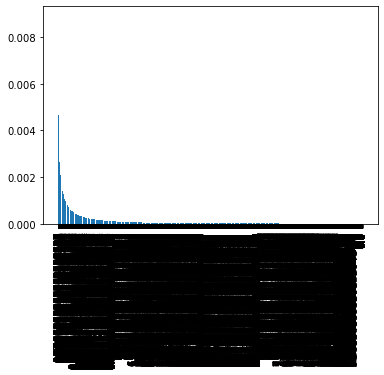

In [72]:
# Get feature importances from our random forest model
importances = model.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(importances)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()